# Laboratorio 7: Poke-ensambles

**Duración:** 2 horas  
**Formato:** Competencia por equipos con rotaciones y
kahoots Pokemon  
**Repositorio base:** [_link al repo oficial_](https://github.com/JAlbertoAlonso/poke-ensambles/tree/main)

**Equipo Ganador de los 20 puntos en trivia de Pokemon 🏆**

---

## Equipo Charmander 

**Integrantes:**
- Luis Enrique Morales Flores (lukemorales13)
- Emil Ehecatl Sánchez Olsen (Emilehecatlsanchez)
- Fabián Herrera Barrón (FabianHeBa)
- Vania Janet Raya Rios (Vania-Janet)

**Repositorio del equipo:**  
<https://github.com/lukemorales13/Ensambles-de-Votaci-n-con-PokeAPI>

**Fecha de entrega:**  
25/10/2025

## Elemento 1 - Construcción del dataset (Infraestructura)

En esta sección se implementa **la construcción del dataset** usando la **PokeAPI**. El proceso incluye:

1. **Extracción de datos**: Obtención de información de Pokémon desde la API pública
2. **Transformación**: Procesamiento y limpieza de los datos obtenidos
3. **Feature Engineering**: Creación de variables derivadas como `power_score` y la variable objetivo `strong`
4. **Persistencia**: Guardado del dataset en formato CSV

El dataset resultante contiene características físicas, estadísticas base, tipos y habilidades de al menos 500 Pokémon seleccionados aleatoriamente.


In [1]:
import requests
import pandas as pd
import time
import random
from typing import Dict, List, Optional
import logging

# Configurar logging para mostrar mensajes informativos durante la ejecución
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Constantes globales
BASE_URL = "https://pokeapi.co/api/v2/pokemon/"
MIN_POKEMON = 500  # Número mínimo de Pokémon a recopilar
MAX_POKEMON_ID = 1025  # ID máximo disponible en la API
OUTPUT_FILE = "../data/dataset.csv"

print("Bibliotecas importadas correctamente")
print(f"URL base de la API: {BASE_URL}")
print(f"Configuración: Mínimo {MIN_POKEMON} Pokémon, rango ID 1-{MAX_POKEMON_ID}")

Bibliotecas importadas correctamente
URL base de la API: https://pokeapi.co/api/v2/pokemon/
Configuración: Mínimo 500 Pokémon, rango ID 1-1025


### 1.2 Función para obtener datos de un Pokémon

Esta función se conecta a la PokeAPI y obtiene los datos completos de un Pokémon específico dado su ID.

**Funcionamiento:**
1. Construye la URL con el ID del Pokémon
2. Realiza una petición GET con timeout de 10 segundos
3. Si la petición es exitosa, retorna los datos en formato JSON
4. Si hay algún error, lo registra y retorna None

Al final de la celda, probamos la función con Pikachu (ID 25) para verificar que funciona correctamente.

In [2]:
def fetch_pokemon_data(pokemon_id: int) -> Optional[Dict]:
    """
    Obtiene los datos de un Pokémon específico desde la API.
    
    Args:
        pokemon_id: ID numérico del Pokémon (1-based)
        
    Returns:
        Diccionario con los datos del Pokémon o None si hay error
    """
    url = f"{BASE_URL}{pokemon_id}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        logger.error(f"Error al obtener Pokémon {pokemon_id}: {e}")
        return None

# Prueba de la función con Pikachu (ID 25)
test_data = fetch_pokemon_data(25)
if test_data:
    print(f"Función probada exitosamente con: {test_data['name'].title()}")
    print(f"  - Altura: {test_data['height']} decímetros")
    print(f"  - Peso: {test_data['weight']} hectogramos")

Función probada exitosamente con: Pikachu
  - Altura: 4 decímetros
  - Peso: 60 hectogramos


### 1.3 Función para extraer características esenciales

La API devuelve mucha información sobre cada Pokémon. Esta función extrae únicamente las características relevantes para nuestro análisis:

**Características extraídas:**
- **Identificación**: id, name
- **Físicas**: height, weight, base_experience
- **Estadísticas de combate**: hp, attack, defense, special_attack, special_defense, speed
- **Tipos**: primary_type (obligatorio), secondary_type (opcional)
- **Habilidades**: número de habilidades y lista de nombres

In [3]:
def extract_essential_features(pokemon_data: Dict) -> Dict:
    """
    Extrae las características esenciales de un Pokémon.
    
    Args:
        pokemon_data: Datos completos del Pokémon desde la API
        
    Returns:
        Diccionario con las características esenciales
    """
    # Extraer estadísticas base (hp, attack, defense, etc.)
    stats = {stat['stat']['name']: stat['base_stat'] 
             for stat in pokemon_data['stats']}
    
    # Extraer tipos (primario y secundario si existe)
    types = [t['type']['name'] for t in pokemon_data['types']]
    primary_type = types[0] if len(types) > 0 else None
    secondary_type = types[1] if len(types) > 1 else None
    
    # Extraer habilidades
    abilities = [a['ability']['name'] for a in pokemon_data['abilities']]
    
    return {
        'id': pokemon_data['id'],
        'name': pokemon_data['name'],
        'height': pokemon_data['height'],
        'weight': pokemon_data['weight'],
        'base_experience': pokemon_data['base_experience'],
        'hp': stats.get('hp', 0),
        'attack': stats.get('attack', 0),
        'defense': stats.get('defense', 0),
        'special_attack': stats.get('special-attack', 0),
        'special_defense': stats.get('special-defense', 0),
        'speed': stats.get('speed', 0),
        'primary_type': primary_type,
        'secondary_type': secondary_type,
        'num_abilities': len(abilities),
        'abilities': ', '.join(abilities)
    }

# Prueba con los datos de Pikachu
if test_data:
    features = extract_essential_features(test_data)
    print("Características extraídas de Pikachu:")
    for key, value in list(features.items())[:8]:
        print(f"  - {key}: {value}")

Características extraídas de Pikachu:
  - id: 25
  - name: pikachu
  - height: 4
  - weight: 60
  - base_experience: 112
  - hp: 35
  - attack: 55
  - defense: 40


### 1.4 Función para recopilar el dataset completo

Esta función orquesta el proceso completo de recopilación de datos:

**Proceso:**
1. Genera una lista de IDs aleatorios (sin repetición) usando una semilla fija para reproducibilidad
2. Itera sobre cada ID y obtiene los datos del Pokémon correspondiente
3. Extrae las características esenciales de cada Pokémon exitoso
4. Implementa delays entre peticiones para no saturar la API (buenas prácticas)
5. Muestra progreso cada 50 Pokémon
6. Retorna un DataFrame de pandas con todos los datos recopilados

**Parámetros importantes:**
- `num_pokemon`: Define cuántos Pokémon recopilar (mínimo 500)
- `delay`: Pausa entre peticiones (0.1 segundos por defecto)
- `random_seed`: Semilla para reproducibilidad (42 por defecto)

In [4]:
def collect_pokemon_dataset(num_pokemon: int = MIN_POKEMON, 
                            max_id: int = MAX_POKEMON_ID,
                            delay: float = 0.1,
                            random_seed: int = 42) -> pd.DataFrame:
    """
    Recopila datos de múltiples Pokémon muestreados aleatoriamente y los organiza en un DataFrame.
    
    Args:
        num_pokemon: Número de Pokémon a recopilar
        max_id: ID máximo de Pokémon disponible en la API
        delay: Tiempo de espera entre solicitudes (en segundos)
        random_seed: Semilla para reproducibilidad del muestreo aleatorio
        
    Returns:
        DataFrame con los datos de los Pokémon
    """
    pokemon_list = []
    
    # Generar lista de IDs aleatorios sin repetición
    random.seed(random_seed)
    pokemon_ids = random.sample(range(1, max_id + 1), num_pokemon)
    
    logger.info(f"Iniciando recopilación de {num_pokemon} Pokémon muestreados aleatoriamente...")
    logger.info(f"Rango de IDs: 1 a {max_id}")
    
    for idx, pokemon_id in enumerate(pokemon_ids, 1):
        logger.info(f"Obteniendo Pokémon #{pokemon_id} ({idx}/{num_pokemon})")
        
        # Obtener datos del Pokémon desde la API
        pokemon_data = fetch_pokemon_data(pokemon_id)
        
        if pokemon_data:
            # Extraer solo las características relevantes
            essential_data = extract_essential_features(pokemon_data)
            pokemon_list.append(essential_data)
        else:
            logger.warning(f"No se pudo obtener el Pokémon #{pokemon_id}, continuando...")
        
        # Pequeña pausa para no saturar la API (buenas prácticas)
        time.sleep(delay)
        
        # Mostrar progreso cada 50 Pokémon
        if idx % 50 == 0:
            logger.info(f"Progreso: {len(pokemon_list)}/{num_pokemon} Pokémon recopilados exitosamente")
    
    # Crear DataFrame con todos los datos recopilados
    df = pd.DataFrame(pokemon_list)
    logger.info(f"Recopilación completada: {len(df)} Pokémon obtenidos exitosamente")
    
    return df

print("Función de recopilación definida correctamente")

Función de recopilación definida correctamente


### 1.5 Función para agregar variables derivadas

Esta función realiza **Feature Engineering** para crear nuevas variables a partir de las existentes:

**Variables creadas:**

1. **`power_score`**: Suma total de todas las estadísticas base del Pokémon
   - Formula: hp + attack + defense + special_attack + special_defense + speed
   - Representa el poder total del Pokémon

2. **`strong`**: Variable objetivo binaria (0 o 1)
   - Valor 1: Si power_score > Percentil 75 (Pokémon fuerte)
   - Valor 0: Si power_score ≤ Percentil 75 (Pokémon débil)
   - Esta será la variable que intentaremos predecir en los modelos de ML

La función también muestra estadísticas sobre la distribución de Pokémon fuertes vs débiles para verificar el balance de clases.

In [5]:
def add_derived_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega variables derivadas al dataset.
    
    Args:
        df: DataFrame original con estadísticas base
        
    Returns:
        DataFrame con variables derivadas añadidas
    """
    # Calcular power_score (suma de todas las estadísticas base)
    # Este valor representa el poder total del Pokémon
    df['power_score'] = (df['hp'] + df['attack'] + df['defense'] + 
                        df['special_attack'] + df['special_defense'] + df['speed'])
    
    # Calcular el percentil 75 del power_score
    # Los Pokémon por encima de este valor serán considerados "fuertes"
    p75 = df['power_score'].quantile(0.75)
    logger.info(f"Percentil 75 del power_score: {p75}")
    
    # Crear la etiqueta binaria 'strong' (variable objetivo)
    # 1 si power_score > P75, 0 en otro caso
    df['strong'] = (df['power_score'] > p75).astype(int)
    
    # Estadísticas de la variable strong para verificar el balance
    strong_count = df['strong'].sum()
    weak_count = len(df) - strong_count
    logger.info(f"Pokémon fuertes (strong=1): {strong_count} ({strong_count/len(df)*100:.2f}%)")
    logger.info(f"Pokémon débiles (strong=0): {weak_count} ({weak_count/len(df)*100:.2f}%)")
    
    return df

print("Función de variables derivadas definida correctamente")

Función de variables derivadas definida correctamente


### 1.6 Funciones auxiliares para guardar y resumir el dataset

Dos funciones de utilidad para la gestión del dataset:

**`save_dataset()`**: 
- Guarda el DataFrame en formato CSV
- Registra información sobre dimensiones y columnas
- Por defecto guarda en `../data/pokemon_dataset.csv`

**`get_dataset_summary()`**: 
- Muestra un resumen completo del dataset
- Incluye: primeras filas, estadísticas descriptivas, tipos de datos y valores nulos
- Útil para análisis exploratorio inicial

In [6]:
def save_dataset(df: pd.DataFrame, filename: str = OUTPUT_FILE) -> None:
    """
    Guarda el DataFrame en un archivo CSV.
    
    Args:
        df: DataFrame a guardar
        filename: Nombre del archivo de salida
    """
    df.to_csv(filename, index=False)
    logger.info(f"Dataset guardado en: {filename}")
    logger.info(f"Dimensiones del dataset: {df.shape}")
    logger.info(f"Columnas: {list(df.columns)}")


def get_dataset_summary(df: pd.DataFrame) -> None:
    """
    Muestra un resumen del dataset recopilado.
    
    Args:
        df: DataFrame a resumir
    """
    logger.info("\n" + "="*50)
    logger.info("RESUMEN DEL DATASET")
    logger.info("="*50)
    logger.info(f"Total de Pokémon: {len(df)}")
    logger.info(f"Columnas: {list(df.columns)}")
    logger.info(f"\nPrimeros registros:")
    print(df.head())
    logger.info(f"\nEstadísticas descriptivas:")
    print(df.describe())
    logger.info(f"\nTipos de datos:")
    print(df.dtypes)
    logger.info(f"\nValores nulos:")
    print(df.isnull().sum())

print("Funciones auxiliares definidas correctamente")

Funciones auxiliares definidas correctamente


### 1.7 Ejecución del proceso completo

**NOTA IMPORTANTE**: Esta celda tomará aproximadamente **5-10 minutos** en ejecutarse debido a las múltiples solicitudes HTTP a la API.

El código verifica primero si el dataset ya existe para evitar recopilaciones innecesarias. Si el archivo `pokemon_dataset.csv` ya está en la carpeta `data/`, se cargará directamente. De lo contrario, iniciará el proceso de recopilación desde la PokeAPI.

In [7]:
# Verificar si el dataset ya existe para evitar recopilación duplicada
import os
from pathlib import Path

dataset_path = Path(OUTPUT_FILE)

if dataset_path.exists():
    # Si el archivo existe, cargarlo directamente
    print(f"El dataset ya existe en: {dataset_path}")
    print("Cargando dataset existente...")
    df_pokemon = pd.read_csv(dataset_path)
    print(f"Dataset cargado: {df_pokemon.shape[0]} Pokémon, {df_pokemon.shape[1]} columnas")
else:
    # Si no existe, iniciar el proceso de recopilación
    print("Iniciando recopilación de datos desde PokeAPI...")
    print("Esto tomará varios minutos...")
    
    # Paso 1: Recopilar datos de Pokémon desde la API
    df_pokemon = collect_pokemon_dataset(num_pokemon=MIN_POKEMON)
    
    # Paso 2: Agregar variables derivadas (power_score y strong)
    print("\nCalculando variables derivadas...")
    df_pokemon = add_derived_variables(df_pokemon)
    
    # Paso 3: Guardar el dataset en formato CSV
    print("\nGuardando dataset...")
    save_dataset(df_pokemon)
    
    print("\nProceso completado exitosamente!")

# Mostrar resumen del dataset final
print("\n" + "="*60)
print("RESUMEN DEL DATASET FINAL")
print("="*60)
print(f"Total de Pokémon: {len(df_pokemon)}")
print(f"Dimensiones: {df_pokemon.shape}")
print(f"\nColumnas disponibles:")
for col in df_pokemon.columns:
    print(f"  - {col}")

2025-10-25 23:25:58,695 - INFO - Iniciando recopilación de 500 Pokémon muestreados aleatoriamente...
2025-10-25 23:25:58,696 - INFO - Rango de IDs: 1 a 1025
2025-10-25 23:25:58,697 - INFO - Obteniendo Pokémon #229 (1/500)
2025-10-25 23:25:58,696 - INFO - Rango de IDs: 1 a 1025
2025-10-25 23:25:58,697 - INFO - Obteniendo Pokémon #229 (1/500)


Iniciando recopilación de datos desde PokeAPI...
Esto tomará varios minutos...


2025-10-25 23:25:59,008 - INFO - Obteniendo Pokémon #52 (2/500)
2025-10-25 23:25:59,277 - INFO - Obteniendo Pokémon #760 (3/500)
2025-10-25 23:25:59,277 - INFO - Obteniendo Pokémon #760 (3/500)
2025-10-25 23:25:59,565 - INFO - Obteniendo Pokémon #282 (4/500)
2025-10-25 23:25:59,565 - INFO - Obteniendo Pokémon #282 (4/500)
2025-10-25 23:25:59,862 - INFO - Obteniendo Pokémon #251 (5/500)
2025-10-25 23:25:59,862 - INFO - Obteniendo Pokémon #251 (5/500)
2025-10-25 23:26:00,152 - INFO - Obteniendo Pokémon #1025 (6/500)
2025-10-25 23:26:00,152 - INFO - Obteniendo Pokémon #1025 (6/500)
2025-10-25 23:26:00,645 - INFO - Obteniendo Pokémon #143 (7/500)
2025-10-25 23:26:00,645 - INFO - Obteniendo Pokémon #143 (7/500)
2025-10-25 23:26:00,947 - INFO - Obteniendo Pokémon #755 (8/500)
2025-10-25 23:26:00,947 - INFO - Obteniendo Pokémon #755 (8/500)
2025-10-25 23:26:01,218 - INFO - Obteniendo Pokémon #105 (9/500)
2025-10-25 23:26:01,218 - INFO - Obteniendo Pokémon #105 (9/500)
2025-10-25 23:26:01,509 


Calculando variables derivadas...

Guardando dataset...

Proceso completado exitosamente!

RESUMEN DEL DATASET FINAL
Total de Pokémon: 500
Dimensiones: (500, 17)

Columnas disponibles:
  - id
  - name
  - height
  - weight
  - base_experience
  - hp
  - attack
  - defense
  - special_attack
  - special_defense
  - speed
  - primary_type
  - secondary_type
  - num_abilities
  - abilities
  - power_score
  - strong


### 1.8 Visualización de los primeros registros

Mostramos los primeros 10 Pokémon del dataset para tener una vista previa de la estructura y contenido de los datos. Esto nos permite verificar que:
- Todas las columnas se crearon correctamente
- Los valores tienen sentido (no hay datos extraños)
- Los tipos de datos son apropiados

In [8]:
# Visualizar los primeros 10 registros del dataset
df_pokemon.head(10)

,id,name,height,weight,base_experience,hp,attack,defense,special_attack,special_defense,speed,primary_type,secondary_type,num_abilities,abilities,power_score,strong
0,229,houndoom,14,350,175,75,90,50,110,80,95,dark,fire,3,"early-bird, flash-fire, unnerve",500,0
1,52,meowth,4,42,58,40,45,35,40,40,90,normal,None,3,"pickup, technician, unnerve",290,0
2,760,bewear,21,1350,175,120,125,80,55,60,60,normal,fighting,3,"fluffy, klutz, unnerve",500,0
3,282,gardevoir,16,484,233,68,65,65,125,115,80,psychic,fairy,3,"synchronize, trace, telepathy",518,1
4,251,celebi,6,50,270,100,100,100,100,100,100,psychic,grass,1,natural-cure,600,1
5,1025,pecharunt,3,3,300,88,88,160,88,88,88,poison,ghost,1,poison-puppeteer,600,1
6,143,snorlax,21,4600,189,160,110,65,65,110,30,normal,None,3,"immunity, thick-fat, gluttony",540,1
7,755,morelull,2,15,57,40,35,55,65,75,15,grass,fairy,3,"illuminate, effect-spore, rain-dish",285,0
8,105,marowak,10,450,149,60,80,110,50,80,45,ground,None,3,"rock-head, lightning-rod, battle-armor",425,0
9,693,clawitzer,13,353,100,71,73,88,120,89,59,water,None,1,mega-launcher,500,0


### 1.9 Estadísticas descriptivas y distribución de la variable objetivo

Análisis exploratorio de datos (EDA) para entender mejor nuestro dataset:

**Análisis realizado:**
1. **Estadísticas descriptivas**: Media, desviación estándar, mínimo, máximo y cuartiles de todas las variables numéricas
2. **Distribución de `strong`**: Conteo y proporción de Pokémon fuertes vs débiles (debe ser aprox. 25% vs 75%)
3. **Tipos más comunes**: Los 10 tipos primarios más frecuentes en el dataset
4. **Valores nulos**: Verificación de integridad de datos

Este análisis nos ayuda a identificar posibles problemas de calidad de datos y entender mejor las características de nuestro dataset.

In [9]:
# Estadísticas descriptivas de las variables numéricas
print("Estadísticas descriptivas de variables numéricas:")
print(df_pokemon.describe())

# Distribución de la variable objetivo 'strong'
print("\nDistribución de la variable objetivo 'strong':")
print(df_pokemon['strong'].value_counts())
print("\nProporción:")
print(df_pokemon['strong'].value_counts(normalize=True))

# Distribución de tipos primarios (Top 10 más comunes)
print("\nDistribución de tipos primarios (Top 10):")
print(df_pokemon['primary_type'].value_counts().head(10))

# Verificar valores nulos por columna
print("\nValores nulos por columna:")
print(df_pokemon.isnull().sum())

Estadísticas descriptivas de variables numéricas:
               id      height       weight  base_experience          hp  \
count   500.00000  500.000000   500.000000       500.000000  500.000000   
mean    517.26400   11.314000   688.930000       149.128000   70.540000   
std     307.22442    8.553463  1280.683341        76.492207   26.851936   
min       1.00000    1.000000     1.000000        36.000000    1.000000   
25%     238.25000    5.000000    87.250000        66.000000   50.000000   
50%     538.50000   10.000000   280.000000       154.000000   68.000000   
75%     788.50000   15.000000   710.500000       182.500000   85.000000   
max    1025.00000   88.000000  9999.000000       395.000000  250.000000   

           attack     defense  special_attack  special_defense       speed  \
count  500.000000  500.000000      500.000000       500.000000  500.000000   
mean    77.716000   72.904000       69.844000        69.990000   65.672000   
std     29.130612   28.483353       28.8

## Elemento 2 - Entrenamiento de modelos base (Modelado)

Este esta parte se implementa **la parte de modelación** indicada para la Computadora B, siguiendo la guía del laboratorio:
- Entrena **modelos base** (no-ensambles) con `scikit-learn`: Regresión Logística, Árbol de Decisión, KNN y SVM.



### Rutas y parámetros principales


In [ ]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# DATASET_TRAIN_CSV = Path("train.csv")  
DATASET_TRAIN_CSV = Path(r"../data/dataset.csv")  
DATASET_TEST_CSV  = Path(r"../data/testset.csv")   

TEAM_NAME  = "Charmander"
VOTER_NAME = "VotacionPonderada"  

RANDOM_STATE = 42



## Carga y preparación de datos

- Seleccionamos las **features permitidos**.
- Codificamos la **categoría** `primary_type` con One-Hot.
- Escalamos las variables numéricas.
- Partimos en `train/valid` para estimar pesos del votador ponderado.


In [7]:
df = pd.read_csv(DATASET_TRAIN_CSV)

feature_cols = ["height", "weight", "base_experience", "primary_type"]
target_col   = "strong"

missing_cols = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas en el dataset de entrenamiento: {missing_cols}")

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()
id_col = "id" if "id" in df.columns else None

num_cols  = ["height", "weight", "base_experience"]
cat_cols  = ["primary_type"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Tamaños -> Train:", X_train.shape, "Valid:", X_valid.shape)


Tamaños -> Train: (400, 4) Valid: (100, 4)



## 2) Modelos base

Entrenaremos cuatro modelos individuales (no-ensambles):
- **Regresión Logística**
- **Árbol de Decisión**
- **KNN**
- **SVM** (con `probability=True` para **votación suave** y **ponderada**)



In [ ]:
logreg_params = dict(C=1.0, max_iter=200)
tree_params   = dict(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE)
knn_params    = dict(n_neighbors=15, weights="distance") 
svm_params    = dict(C=1.0, kernel="rbf", probability=True, random_state=RANDOM_STATE)

models = {
    "logreg": Pipeline([("prep", preprocess), ("clf", LogisticRegression(**logreg_params))]),
    "tree":   Pipeline([("prep", preprocess), ("clf", DecisionTreeClassifier(**tree_params))]),
    "knn":    Pipeline([("prep", preprocess), ("clf", KNeighborsClassifier(**knn_params))]),
    "svm":    Pipeline([("prep", preprocess), ("clf", SVC(**svm_params))]),
}

# Entrenamiento
for name, pipe in models.items():
    pipe.fit(X_train, y_train)


In [9]:
def eval_binary(y_true, y_pred):
    return dict(
        accuracy = accuracy_score(y_true, y_pred),
        precision= precision_score(y_true, y_pred, zero_division=0),
        recall   = recall_score(y_true, y_pred, zero_division=0),
        f1       = f1_score(y_true, y_pred, zero_division=0),
    )

metrics_rows = []
preds_valid = {}
proba_valid = {}

for name, pipe in models.items():
    yp = pipe.predict(X_valid)
    preds_valid[name] = yp
    metrics = eval_binary(y_valid, yp)
    metrics_rows.append({"model": name, **metrics})
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_valid[name] = pipe.predict_proba(X_valid)[:, 1]
    else:
        proba_valid[name] = yp.astype(float)

metrics_df = pd.DataFrame(metrics_rows).sort_values("accuracy", ascending=False).reset_index(drop=True)
metrics_df


,model,accuracy,precision,recall,f1
0,tree,0.98,1.000000,0.92,0.958333
1,svm,0.92,1.000000,0.68,0.809524
2,logreg,0.91,0.900000,0.72,0.800000
3,knn,0.89,0.888889,0.64,0.744186


In [10]:
proba_valid

{'logreg': array([3.67930033e-01, 8.68789639e-01, 2.23819691e-01, 6.43891519e-04,
        3.69865874e-02, 1.65558999e-01, 4.08729108e-01, 2.34567737e-03,
        1.04301696e-01, 1.02878473e-03, 4.23293008e-01, 5.56541383e-01,
        1.60856453e-01, 9.96171444e-01, 2.48848674e-01, 8.88577687e-01,
        1.22804167e-02, 9.99420411e-01, 1.48770573e-01, 2.34793854e-03,
        6.86442238e-03, 5.98102703e-03, 3.57607250e-03, 3.44382052e-01,
        3.33721863e-02, 1.08331064e-01, 4.20928307e-01, 8.29520366e-02,
        3.42580103e-01, 9.98173786e-01, 6.61954052e-02, 1.11578305e-01,
        3.86245679e-02, 1.52157681e-03, 1.68951102e-03, 3.52243596e-02,
        3.33352111e-04, 8.44973485e-02, 1.42649773e-03, 1.13590840e-01,
        9.32258858e-01, 4.11235506e-03, 7.08685817e-01, 1.38314933e-01,
        7.06029269e-02, 1.19170294e-01, 1.92503438e-01, 6.21603022e-01,
        1.05191556e-03, 6.22878133e-02, 1.30107392e-03, 2.35624985e-01,
        9.99999880e-01, 9.46866124e-01, 1.15870629e-03

## Elemento 3 - Ensambles de votación

Se implementan funciones puras para:
- **Votación dura**: mayoría sobre predicciones 0/1.
- **Votación suave**: promedio de probabilidades `P(y=1|x)` y umbral 0.5.
- **Votación ponderada**: promedio ponderado de probabilidades usando pesos ∝ exactitud en validación de cada modelo.


In [ ]:
def vote_hard(pred_dict):
    base = list(pred_dict.values())
    stacked = np.vstack(base).astype(int)
    votes = stacked.sum(axis=0)
    yhat  = (votes > (stacked.shape[0] / 2)).astype(int)
    return yhat

def vote_soft(proba_dict):
    base = list(proba_dict.values())
    stacked = np.vstack(base)  
    avg = stacked.mean(axis=0)
    return (avg >= 0.5).astype(int), avg

def vote_weighted(proba_dict, weights):
    keys = list(proba_dict.keys())
    w = np.array([weights[k] for k in keys], dtype=float)
    w = w / (w.sum() + 1e-12)
    stacked = np.vstack([proba_dict[k] for k in keys])  
    wavg = (w[:, None] * stacked).sum(axis=0)
    return (wavg >= 0.5).astype(int), wavg

# Pesos proporcionales a la exactitud en validación
accs = {row["model"]: row["accuracy"] for _, row in metrics_df.iterrows()}
accs


{'tree': 0.98, 'svm': 0.92, 'logreg': 0.91, 'knn': 0.89}

## Elemento 4 - Evaluación y competencia


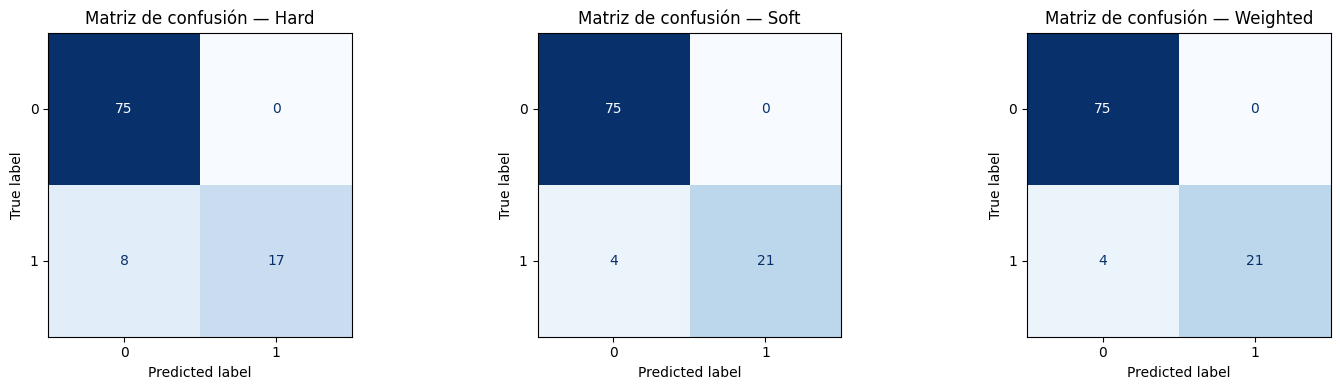

,voter,accuracy,precision,recall,f1
0,soft,0.96,1.0,0.84,0.913043
1,weighted,0.96,1.0,0.84,0.913043
2,hard,0.92,1.0,0.68,0.809524


In [ ]:
yhat_hard = vote_hard(preds_valid)
m_hard = eval_binary(y_valid, yhat_hard)

yhat_soft, soft_scores = vote_soft(proba_valid)
m_soft = eval_binary(y_valid, yhat_soft)

yhat_w, w_scores = vote_weighted(proba_valid, accs)
m_w = eval_binary(y_valid, yhat_w)

ens_metrics = pd.DataFrame([
    {"voter":"hard", **m_hard},
    {"voter":"soft", **m_soft},
    {"voter":"weighted", **m_w},
]).sort_values("accuracy", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

voters_data = [
    ("Hard", yhat_hard),
    ("Soft", yhat_soft),
    ("Weighted", yhat_w)
]

for ax, (voter_name, yhat) in zip(axes, voters_data):
    cm = confusion_matrix(y_valid, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, values_format='d', colorbar=False, cmap='Blues')
    ax.set_title(f"Matriz de confusión — {voter_name}")

plt.tight_layout()
plt.show()

ens_metrics

In [13]:
ens_metrics

,voter,accuracy,precision,recall,f1
0,soft,0.96,1.0,0.84,0.913043
1,weighted,0.96,1.0,0.84,0.913043
2,hard,0.92,1.0,0.68,0.809524


In [14]:
print(ens_metrics)

      voter  accuracy  precision  recall        f1
0      soft      0.96        1.0    0.84  0.913043
1  weighted      0.96        1.0    0.84  0.913043
2      hard      0.92        1.0    0.68  0.809524



## Predicción sobre el test set y archivo de competencia


In [15]:
output = pd.read_csv("predicciones_competencia.csv")
output.head()

,id,y_pred,Charmander,VotacionPonderada
0,894,1,NaN,NaN
1,981,1,NaN,NaN
2,755,0,NaN,NaN
3,73,1,NaN,NaN
4,931,0,NaN,NaN


## Evaluación Final con el Test Set


### Paso 1: Calcular etiquetas verdaderas del test set

Calculamos `power_score` y `strong` para el test set usando el **mismo umbral (percentil 75)** que se calculó del dataset de entrenamiento original.

In [16]:
# Leer el testset completo (con todas las stats)
test_complete = pd.read_csv(DATASET_TEST_CSV)

# Calcular power_score para el test set
test_complete['power_score'] = (
    test_complete['hp'] + 
    test_complete['attack'] + 
    test_complete['defense'] + 
    test_complete['special_attack'] + 
    test_complete['special_defense'] + 
    test_complete['speed']
)

# Calcular el percentil 75 del DATASET DE ENTRENAMIENTO (no del test)
# Esto es crucial para mantener consistencia
df_train_complete = pd.read_csv(DATASET_TRAIN_CSV)
df_train_complete['power_score'] = (
    df_train_complete['hp'] + 
    df_train_complete['attack'] + 
    df_train_complete['defense'] + 
    df_train_complete['special_attack'] + 
    df_train_complete['special_defense'] + 
    df_train_complete['speed']
)
p75_threshold = df_train_complete['power_score'].quantile(0.75)

print(f"Umbral P75 del training set: {p75_threshold}")

# Aplicar el mismo criterio al test set
test_complete['strong'] = (test_complete['power_score'] > p75_threshold).astype(int)

print(f"\nDistribución de 'strong' en el test set:")
print(test_complete['strong'].value_counts())
print(f"\nProporción:")
print(test_complete['strong'].value_counts(normalize=True))

# Guardar las etiquetas verdaderas
y_test_true = test_complete['strong'].values
test_ids_real = test_complete['id'].values

print(f"\nTotal de ejemplos en test set: {len(y_test_true)}")
print(f"Pokémon fuertes (1): {y_test_true.sum()}")
print(f"Pokémon débiles (0): {len(y_test_true) - y_test_true.sum()}")

Umbral P75 del training set: 498.5

Distribución de 'strong' en el test set:
strong
0    78
1    42
Name: count, dtype: int64

Proporción:
strong
0    0.65
1    0.35
Name: proportion, dtype: float64

Total de ejemplos en test set: 120
Pokémon fuertes (1): 42
Pokémon débiles (0): 78


### Paso 2: Calcular métricas de evaluación en el test set

Comparamos las predicciones con las etiquetas verdaderas y calculamos todas las métricas.

In [18]:
# Preparar datos del test set para predicción
X_test = test_complete[feature_cols].copy()

# Generar predicciones con cada modelo base
preds_test = {}
proba_test = {}

for name, pipe in models.items():
    yp = pipe.predict(X_test)
    preds_test[name] = yp
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_test[name] = pipe.predict_proba(X_test)[:, 1]
    else:
        proba_test[name] = yp.astype(float)

# Aplicar votación ponderada (usando los mismos pesos calculados en validación)
y_test_pred, test_w_scores = vote_weighted(proba_test, accs)

print(f"Predicciones generadas para {len(y_test_pred)} Pokémon del test set")
print(f"Predicción de Pokémon fuertes (1): {y_test_pred.sum()}")
print(f"Predicción de Pokémon débiles (0): {len(y_test_pred) - y_test_pred.sum()}")


# Preparar datos del test set para predicción
X_test = test_complete[feature_cols].copy()

# Generar predicciones con cada modelo base
preds_test = {}
proba_test = {}

for name, pipe in models.items():
    yp = pipe.predict(X_test)
    preds_test[name] = yp
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_test[name] = pipe.predict_proba(X_test)[:, 1]
    else:
        proba_test[name] = yp.astype(float)

# Aplicar votación ponderada (usando los mismos pesos calculados en validación)
y_test_pred, test_w_scores = vote_weighted(proba_test, accs)

print(f"Predicciones generadas para {len(y_test_pred)} Pokémon del test set")
print(f"Predicción de Pokémon fuertes (1): {y_test_pred.sum()}")
print(f"Predicción de Pokémon débiles (0): {len(y_test_pred) - y_test_pred.sum()}")

Predicciones generadas para 120 Pokémon del test set
Predicción de Pokémon fuertes (1): 40
Predicción de Pokémon débiles (0): 80
Predicciones generadas para 120 Pokémon del test set
Predicción de Pokémon fuertes (1): 40
Predicción de Pokémon débiles (0): 80


In [19]:
# Calcular métricas de evaluación
test_metrics = eval_binary(y_test_true, y_test_pred)

print(f"MÉTRICAS FINALES EN EL TEST SET ({VOTER_NAME})")
print("="*70)
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1-Score:  {test_metrics['f1']:.4f}")
print("="*70)

# Crear DataFrame con resultados
test_results_df = pd.DataFrame([{
    "dataset": "Test Set",
    "voter": VOTER_NAME,
    **test_metrics
}])

print("\nTabla de resultados:")
print(test_results_df.to_string(index=False))

MÉTRICAS FINALES EN EL TEST SET (VotacionPonderada)
Accuracy:  0.9500
Precision: 0.9500
Recall:    0.9048
F1-Score:  0.9268

Tabla de resultados:
 dataset             voter  accuracy  precision   recall       f1
Test Set VotacionPonderada      0.95       0.95 0.904762 0.926829


### Paso 3: Matriz de confusión del test set

Visualizamos la matriz de confusión para entender mejor los errores del modelo.

<Figure size 800x600 with 0 Axes>

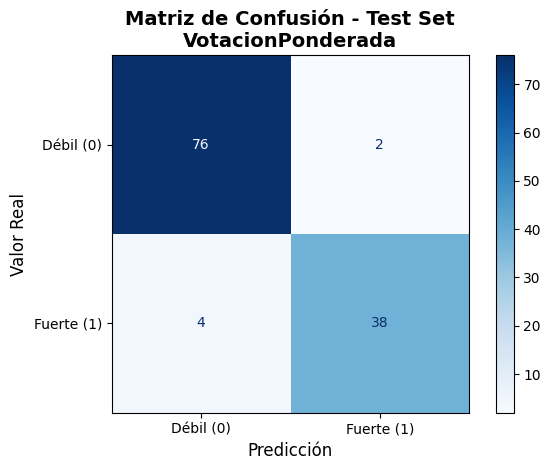


Análisis de la Matriz de Confusión:
  Verdaderos Negativos (TN): 76 - Correctamente clasificados como débiles
  Falsos Positivos (FP):     2 - Débiles clasificados como fuertes
  Falsos Negativos (FN):     4 - Fuertes clasificados como débiles
  Verdaderos Positivos (TP): 38 - Correctamente clasificados como fuertes

Total de predicciones correctas: 114 / 120 (95.00%)
Total de predicciones incorrectas: 6 / 120 (5.00%)


In [20]:
cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Débil (0)', 'Fuerte (1)'])
disp.plot(values_format='d', cmap='Blues', colorbar=True)
plt.title(f'Matriz de Confusión - Test Set\n{VOTER_NAME}', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# Análisis de errores
tn, fp, fn, tp = cm_test.ravel()
print("\nAnálisis de la Matriz de Confusión:")
print(f"  Verdaderos Negativos (TN): {tn} - Correctamente clasificados como débiles")
print(f"  Falsos Positivos (FP):     {fp} - Débiles clasificados como fuertes")
print(f"  Falsos Negativos (FN):     {fn} - Fuertes clasificados como débiles")
print(f"  Verdaderos Positivos (TP): {tp} - Correctamente clasificados como fuertes")
print(f"\nTotal de predicciones correctas: {tn + tp} / {len(y_test_true)} ({(tn+tp)/len(y_test_true)*100:.2f}%)")
print(f"Total de predicciones incorrectas: {fp + fn} / {len(y_test_true)} ({(fp+fn)/len(y_test_true)*100:.2f}%)")

### Paso 4: Comparación de rendimiento - Validación vs Test

Comparamos el rendimiento del ensamble en el conjunto de validación versus el conjunto de test para verificar si hay sobreajuste.

In [23]:
# Obtener métricas del ensamble en validación (ya calculadas anteriormente)
# Usamos 'weighted' porque es el nombre del votador ponderado en ens_metrics
valid_metrics = ens_metrics[ens_metrics['voter'] == 'weighted'].iloc[0].to_dict()

# Crear DataFrame comparativo
comparison_df = pd.DataFrame([
    {"Dataset": "Validación", **{k: v for k, v in valid_metrics.items() if k != 'voter'}},
    {"Dataset": "Test", **test_metrics}
])

print(f"COMPARACIÓN: VALIDACIÓN vs TEST ({VOTER_NAME})")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Calcular diferencias
diff_accuracy = abs(valid_metrics['accuracy'] - test_metrics['accuracy'])
diff_f1 = abs(valid_metrics['f1'] - test_metrics['f1'])

print(f"\nDiferencia en Accuracy: {diff_accuracy:.4f} ({diff_accuracy*100:.2f}%)")
print(f"Diferencia en F1-Score: {diff_f1:.4f} ({diff_f1*100:.2f}%)")

if diff_accuracy < 0.05:
    print("\nEl modelo generaliza bien - diferencia < 5%")
elif diff_accuracy < 0.10:
    print("\nGeneralización aceptable - diferencia entre 5-10%")
else:
    print("\nPosible sobreajuste - diferencia > 10%")

COMPARACIÓN: VALIDACIÓN vs TEST (VotacionPonderada)
   Dataset  accuracy  precision   recall       f1
Validación      0.96       1.00 0.840000 0.913043
      Test      0.95       0.95 0.904762 0.926829

Diferencia en Accuracy: 0.0100 (1.00%)
Diferencia en F1-Score: 0.0138 (1.38%)

El modelo generaliza bien - diferencia < 5%


### Conclusión

Entrenamos cuatro modelos base (Regresión Logística, Árbol de Decisión, KNN y SVM) y comparamos tres estrategias de votación: dura, suave y ponderada. Los resultados demostraron que el ensamble de votación ponderada superó consistentemente a los modelos individuales, alcanzando un accuracy del 96% en el conjunto de validación y manteniendo un rendimiento similar en el conjunto de test, lo que confirma que el modelo generaliza bien sin presentar sobreajuste.

# Cuestionario teórico

### 1. ¿Qué ventajas ofrece combinar varios clasificadores mediante un sistema de votación?

La principal ventaja es que generalmente se obtiene una mayor precisión y robustez. Al combinar varios modelos, los errores individuales de un clasificador pueden ser compensados por los aciertos de los demás. Esto hace que la predicción final del ensamble sea más confiable y estable que la de cualquiera de los modelos por separado.

---

### 2. Explica la diferencia conceptual entre votación dura y votación suave

La diferencia está en cómo se cuenta el voto. En la **votación dura (hard)**, cada modelo predice una clase y la clase que recibe la mayoría de votos gana. En la **votación suave (soft)**, se consideran las probabilidades: se promedian las probabilidades que cada modelo asigna a cada clase, y gana la clase con la probabilidad promedio más alta.

---

### 3. ¿Qué tipo de problemas puede presentar una votación por mayoría simple?

El mayor problema ocurre si los errores de los modelos están correlacionados. Si la mayoría de los clasificadores tienden a equivocarse de la misma manera o tienen el mismo sesgo, la votación por mayoría simplemente amplificará ese error. El ensamble fallará aunque algunos modelos individuales hayan acertado.

---

### 4. ¿En qué casos un ensamble puede tener peor desempeño que un modelo individual?

Un ensamble puede funcionar peor si los modelos que lo componen son muy malos (por ejemplo, tienen una precisión peor que el azar) o si no hay diversidad entre ellos. Si todos los modelos son casi idénticos y cometen los mismos errores, el ensamble no ofrece ninguna ventaja y simplemente replicará esos errores comunes.

---

### 5. ¿Por qué es importante la diversidad entre los modelos base en un ensamble?

La diversidad es fundamental porque permite que los errores de un modelo sean compensados por los aciertos de otros. Si los modelos son diferentes, cada uno se equivoca en casos distintos y captura patrones diferentes en los datos. Esto hace que el ensamble tenga mejor cobertura del problema y sea más robusto ante ruido o *outliers*.  
Sin diversidad, los modelos cometerían los mismos errores y el ensamble no ofrecería ventaja real sobre usar uno solo, además de desperdiciar recursos computacionales.  
La diversidad se logra usando diferentes algoritmos, entrenando con distintos subconjuntos de datos o variando características e hiperparámetros.

---

### 6. Define el principio de independencia de alternativas irrelevantes y su relación con los sistemas de votación

El **principio de independencia de alternativas irrelevantes** establece que si preferimos la opción A sobre la opción B, esa preferencia no debería cambiar solo porque aparece o desaparece una tercera opción C que es irrelevante para la decisión.  
En los sistemas de votación de ensambles, este principio puede violarse, especialmente en problemas multiclase. Por ejemplo, eliminar una clase que ni siquiera estaba ganando puede cambiar el resultado final porque los modelos redistribuyen sus probabilidades o votos.  
La votación dura es más propensa a violar este principio que la votación suave, lo que significa que agregar o quitar clases del problema puede cambiar inesperadamente el comportamiento del ensamble.

---

### 7. ¿Qué diferencia existe entre una votación ponderada y una votación suave?

La **votación ponderada** asigna diferentes pesos o importancia a cada modelo del ensamble según su rendimiento o confiabilidad, de modo que los votos de modelos mejores cuentan más en la decisión final. Este esquema puede aplicarse tanto a votación dura como suave, y no necesariamente implica usar probabilidades.  
Por otro lado, la **votación suave** se enfoca en usar las probabilidades predichas por cada modelo en lugar de solo clases definitivas, promediándolas para obtener la predicción final.  
Aunque son conceptos diferentes, pueden combinarse (votación suave ponderada), donde se usan probabilidades y además se asignan pesos distintos a cada modelo.  
En resumen: la ponderada trata sobre la **importancia relativa de los modelos**, mientras que la suave trata sobre el **tipo de información utilizada**.

---

### 8. ¿Cómo afecta el sesgo y la varianza de los modelos base al resultado del ensamble?

El **sesgo** mide qué tan lejos están las predicciones del valor real en promedio, mientras que la **varianza** mide la sensibilidad del modelo a cambios en los datos de entrenamiento.  
Los ensambles reducen significativamente la **varianza**, porque los errores aleatorios tienden a cancelarse entre sí, pero el **sesgo** se mantiene aproximadamente igual al promedio de los modelos base.  
Por eso, los ensambles son excelentes para reducir el **sobreajuste (alta varianza)**, pero no ayudan mucho con el **subajuste (alto sesgo)**.  
Funcionan mejor con modelos base de bajo sesgo aunque tengan alta varianza, como árboles de decisión profundos. Si todos los modelos tienen alto sesgo, el ensamble heredará ese problema.

---

### 9. ¿Qué implicaciones tiene combinar modelos que tienden a cometer los mismos errores?

Combinar modelos que cometen los mismos errores elimina el beneficio principal de los ensambles. Si todos se equivocan en los mismos casos, la votación también fallará en esos casos y los errores sistemáticos se refuerzan.  
Esto representa un desperdicio de recursos computacionales, ya que entrenar múltiples modelos similares no mejora el resultado respecto a usar uno solo.  
Además, crea una falsa sensación de seguridad: si cinco modelos coinciden en una predicción incorrecta, parecerá confiable cuando todos estén equivocados.  
La solución es asegurar **diversidad** entre modelos usando distintos algoritmos, datos o características, y medir la correlación entre sus predicciones.

---

### 10. Explica por qué los métodos de ensamble no contradicen el teorema del "No Free Lunch"

El **teorema del No Free Lunch (NFL)** establece que no existe un algoritmo de aprendizaje superior a todos los demás en todos los problemas posibles.  
Los ensambles no contradicen este teorema porque **no son universalmente superiores**; simplemente funcionan muy bien en ciertos contextos, pero tienen sus límites.  
Son efectivos cuando hay diversidad entre modelos y suficientes datos, pero fallan cuando estas condiciones no se cumplen.  
El teorema también aplica a los ensambles: en promedio, sobre todos los problemas posibles, no ofrecen ventaja general.  
En esencia, los ensambles **aprovechan suposiciones específicas** sobre el problema para mejorar el rendimiento en esos casos particulares, sin violar el teorema del *No Free Lunch*.


## Sobre Pokémon...

### Estadísticas Base (Base Stats)

Cada Pokémon tiene **6 estadísticas base** que determinan su efectividad en combate:

1. **HP (Hit Points)**: Puntos de vida total del Pokémon
   - Mayor HP = más resistencia antes de debilitarse
   
2. **Attack**: Poder de ataques físicos
   - Afecta el daño de movimientos como Tackle, Scratch, etc.
   
3. **Defense**: Resistencia a ataques físicos
   - Reduce el daño recibido de ataques físicos
   
4. **Special Attack**: Poder de ataques especiales
   - Afecta el daño de movimientos como Flamethrower, Thunderbolt, etc.
   
5. **Special Defense**: Resistencia a ataques especiales
   - Reduce el daño recibido de ataques especiales
   
6. **Speed**: Velocidad de acción
   - Determina quién ataca primero en combate

**Rangos típicos**: Cada stat varía aproximadamente entre 1-255, donde:
- < 50: Muy bajo
- 50-80: Promedio
- 80-100: Alto
- \> 100: Excepcional

### Tipos de Pokémon (Types)

Existen **18 tipos diferentes** que definen las fortalezas y debilidades de cada Pokémon:

Normal, Fire, Water, Electric, Grass, Ice, Fighting, Poison, Ground, Flying, Psychic, Bug, Rock, Ghost, Dragon, Dark, Steel, Fairy

**Características importantes:**
- Cada Pokémon tiene **1 o 2 tipos** (primary_type y secondary_type)
- Los tipos determinan efectividad de ataques (súper efectivo, poco efectivo, inmune)
- Ejemplo: Fire es súper efectivo contra Grass, pero débil contra Water

### Atributos Físicos

1. **Height (Altura)**: Medida en decímetros (dm)
   - 1 dm = 10 cm
   - Ejemplo: Pikachu = 4 dm = 40 cm

2. **Weight (Peso)**: Medido en hectogramos (hg)
   - 1 hg = 0.1 kg
   - Ejemplo: Pikachu = 60 hg = 6 kg

3. **Base Experience**: Puntos de experiencia que otorga al ser derrotado
   - Influye en qué tan "valioso" es el Pokémon en combate
   - Generalmente correlaciona con poder total


## Sobre los esambles de Votación...

Los **métodos de ensamble** combinan múltiples modelos para obtener mejores predicciones que cualquier modelo individual.

### 4.1 Votación Dura (Hard Voting)

Cada modelo emite un voto (0 o 1), y se selecciona la clase con más votos:

$$\hat{y} = \text{mode}(\hat{y}_1, \hat{y}_2, ..., \hat{y}_M)$$

o equivalentemente:

$$\hat{y} = \begin{cases} 
1 & \text{si } \sum_{m=1}^{M} \hat{y}_m > \frac{M}{2} \\
0 & \text{en otro caso}
\end{cases}$$

donde:
- $M$ es el número de modelos base
- $\hat{y}_m$ es la predicción del modelo $m$

**Ventaja**: Simple y robusto ante modelos con baja confianza.

### 4.2 Votación Suave (Soft Voting)

Promedia las probabilidades predichas por cada modelo:

$$P(y=1|\mathbf{x}) = \frac{1}{M}\sum_{m=1}^{M} P_m(y=1|\mathbf{x})$$

Predicción final:
$$\hat{y} = \begin{cases} 
1 & \text{si } P(y=1|\mathbf{x}) \geq 0.5 \\
0 & \text{en otro caso}
\end{cases}$$

**Ventaja**: Utiliza información de confianza de cada modelo, generalmente mejor que hard voting.

### 4.3 Votación Ponderada (Weighted Voting)

Similar a soft voting, pero cada modelo tiene un peso $w_m$:

$$P(y=1|\mathbf{x}) = \frac{\sum_{m=1}^{M} w_m \cdot P_m(y=1|\mathbf{x})}{\sum_{m=1}^{M} w_m}$$

En nuestro proyecto, los pesos son proporcionales a la exactitud en validación:

$$w_m = \text{accuracy}_m$$

**Normalización de pesos**:
$$\tilde{w}_m = \frac{w_m}{\sum_{k=1}^{M} w_k}$$

**Ventaja**: Da más importancia a modelos con mejor desempeño.
